In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import glob
import os
import random
import keras
from tensorflow.keras.utils import plot_model
from keras import backend as K
from keras import layers
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cv2
from tqdm import tqdm
from keras.callbacks import EarlyStopping
# from keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB2
# from keras.applications.vgg16 import VGG16, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from collections import Counter
from sklearn.model_selection import train_test_split
import sklearn
from collections import Counter
from pandas import DataFrame
import gc
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

In [2]:
# efficientNetB2 = EfficientNetB2(weights = None ,include_top=False, input_shape=input_shape)
# len(efficientNetB2.layers)

In [3]:
#Encode target variables
def encode_target_variable(y_train,y_val):

    class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    d_class_weights = dict(enumerate(class_weights))
    onehot_encoder = OneHotEncoder(sparse=False)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_train = y_train.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    y_train_onehot = onehot_encoder.fit_transform(y_train)
    y_val_onehot = onehot_encoder.fit_transform(y_val)
    return y_train_onehot, y_val_onehot, d_class_weights

In [4]:
train_csv_path = "../input/cassava-leaf-disease-classification/train.csv"
label_json_path = "../input/cassava-leaf-disease-classification/label_num_to_disease_map.json"
images_dir_path = "../input/cassava-leaf-disease-classification/train_images"
test_csv_path = "../input/cassava-leaf-disease-classification/sample_submission.csv"
train_csv = pd.read_csv(train_csv_path)
train_csv['label'] = train_csv['label'].astype('string')
#Undersample
# x_undersampled, y_undersampled = resample(train_csv.loc[train_csv['label'] == 3,'image_id'], train_csv.loc[train_csv['label'] == 3,'label'],
#                  replace=True,
#                  n_samples= 3000,
#                  random_state=123)

# undersample_df = pd.DataFrame(columns=['image_id','label'])
# undersample_df['image_id'] = x_undersampled
# undersample_df['label'] = y_undersampled

# train_df = undersample_df.append([train_csv.loc[train_csv['label'] == 0,:],train_csv.loc[train_csv['label'] == 1,:],train_csv.loc[train_csv['label'] == 2,:],train_csv.loc[train_csv['label'] == 4,:]])
# train_df['label'] = train_df['label'].astype('string')

x_train, x_val, y_train, y_val = train_test_split(train_csv['image_id'], train_csv['label'], test_size = 0.05, random_state = 27, stratify=train_csv['label'])

y_train_onehot, y_val_onehot, d_class_weights = encode_target_variable(y_train,y_val)


#train df
df_train = pd.DataFrame(columns=['image_id','label'])
df_train['image_id'] = x_train
df_train['label'] = y_train
#validation df
df_val = pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = x_val
df_val['label'] = y_val

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

label_class = pd.read_json(label_json_path, orient='index')
label_class = label_class.values.flatten().tolist()
IMG_SIZE = 600
BATCH_SIZE = 32
EPOCHS = 4
CHANNELS = 3

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=5020     3
18807    1
8537     3
16442    3
15754    4
        ..
13788    1
18853    3
4310     1
17081    2
4939     3
Name: label, Length: 20327, dtype: string as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [5]:
print("Label names :")
for i, label in enumerate(label_class):
    print(f" {i}. {label}")

Label names :
 0. Cassava Bacterial Blight (CBB)
 1. Cassava Brown Streak Disease (CBSD)
 2. Cassava Green Mottle (CGM)
 3. Cassava Mosaic Disease (CMD)
 4. Healthy


In [6]:
# Bi-tempered log loss for noisy labels datasets

# Tempered Softmax Activation

def log_t(u, t):
    epsilon = 1e-7
    """Compute log_t for `u`."""
    if t == 1.0:
        return tf.math.log(u + epsilon)
    else:
        return (u**(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u`."""
    if t == 1.0:
        return tf.math.exp(u)
    else:
        return tf.math.maximum(0.0, 1.0 + (1.0 - t) * u) ** (1.0 / (1.0 - t))

def compute_normalization_fixed_point(y_pred, t2, num_iters=5):
    """Returns the normalization value for each example (t > 1.0).
    Args:
    y_pred: A multi-dimensional tensor with last dimension `num_classes`.
    t2: A temperature 2 (> 1.0 for tail heaviness).
    num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as y_pred with the last dimension being 1.
    """
    mu = tf.math.reduce_max(y_pred, -1, keepdims=True)
    normalized_y_pred_step_0 = y_pred - mu
    normalized_y_pred = normalized_y_pred_step_0
    i = 0
    while i < num_iters:
        i += 1
        logt_partition = tf.math.reduce_sum(exp_t(normalized_y_pred, t2),-1, keepdims=True)
        normalized_y_pred = normalized_y_pred_step_0 * (logt_partition ** (1.0 - t2))
  
    logt_partition = tf.math.reduce_sum(exp_t(normalized_y_pred, t2), -1, keepdims=True)
    return -log_t(1.0 / logt_partition, t2) + mu

def compute_normalization(y_pred, t2, num_iters=5):
    """Returns the normalization value for each example.
    Args:
    y_pred: A multi-dimensional tensor with last dimension `num_classes`.
    t2: A temperature 2 (< 1.0 for finite support, > 1.0 for tail heaviness).
    num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    if t2 < 1.0:
        return None # not implemented as these values do not occur in the authors experiments...
    else:
        return compute_normalization_fixed_point(y_pred, t2, num_iters)

def tempered_softmax_activation(x, t2=1., num_iters=5):
    """Tempered softmax function.
    Args:
    x: A multi-dimensional tensor with last dimension `num_classes`.
    t2: A temperature tensor > 0.0.
    num_iters: Number of iterations to run the method.
    Returns:
    A probabilities tensor.
    """
    if t2 == 1.0:
        normalization_constants = tf.math.log(tf.math.reduce_sum(tf.math.exp(x), -1, keepdims=True))
    else:
        normalization_constants = compute_normalization(x, t2, num_iters)

    return exp_t(x - normalization_constants, t2)

class TemperedSoftmax(tf.keras.layers.Layer):
    def __init__(self, t2=1.0, num_iters=5, **kwargs):
        super(TemperedSoftmax, self).__init__(**kwargs)
        self.t2 = t2
        self.num_iters = num_iters

    def call(self, inputs):
        return tempered_softmax_activation(inputs, t2=self.t2, num_iters=self.num_iters)

In [7]:
def bi_tempered_logistic_loss(y_pred, y_true, t1, label_smoothing=0.0):
    """Bi-Tempered Logistic Loss with custom gradient.
    Args:
    y_pred: A multi-dimensional probability tensor with last dimension `num_classes`.
    y_true: A tensor with shape and dtype as y_pred.
    t1: Temperature 1 (< 1.0 for boundedness).
    label_smoothing: A float in [0, 1] for label smoothing.
    Returns:
    A loss tensor.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    if label_smoothing > 0.0:
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = (1 - num_classes /(num_classes - 1) * label_smoothing) * y_true + label_smoothing / (num_classes - 1)

    temp1 = (log_t(y_true + 1e-7, t1) - log_t(y_pred, t1)) * y_true
    temp2 = (1 / (2 - t1)) * (tf.math.pow(y_true, 2 - t1) - tf.math.pow(y_pred, 2 - t1))
    loss_values = temp1 - temp2

    return tf.math.reduce_sum(loss_values, -1)

class BiTemperedLogisticLoss(tf.keras.losses.Loss):
    def __init__(self, t1, label_smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        return bi_tempered_logistic_loss(y_pred, y_true, self.t1, self.label_smoothing)

In [8]:
train_gen = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 180,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 25,
                    zoom_range = 0.5,
                    horizontal_flip = True,
                    vertical_flip = True,
                    channel_shift_range=15.0,
                    brightness_range=(0.4, 0.6),
                    fill_mode = 'reflect'
                               )


                                    
    
valid_gen = ImageDataGenerator(tf.keras.applications.efficientnet.preprocess_input,
                               validation_split = 0.2
                              )


In [9]:
train_generator = train_gen.flow_from_dataframe(
                            dataframe=df_train,
                            directory = images_dir_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            shuffle = True,
                            subset = "training"

)

valid_generator = valid_gen.flow_from_dataframe(
                            dataframe=df_val,
                            directory = images_dir_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            subset = "validation"
)


Found 20327 validated image filenames belonging to 5 classes.
Found 214 validated image filenames belonging to 5 classes.


In [10]:
def create_model_0(input_shape):
    input_img = Input(shape=input_shape)  
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
    y = Dropout(0.4)(y)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    z = MaxPooling2D((2, 2), padding='same')(z)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)
    z = MaxPooling2D((2, 2), padding='same')(z)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)

    #out = layers.concatenate([x, y, z])
    out = layers.Flatten()(z)
    out = Dense(16, activation='relu')(out)
    out = Dense(5, activation='softmax')(out)
    
    model_f = Model(inputs=[input_img], outputs=[out])
    model_f.summary()
    return model_f

In [11]:

# efficientNetB3 = EfficientNetB3(weights = None ,include_top=False, input_shape=input_shape)
# print("Number of layers in the base model: ", len(efficientNetB3.layers))

In [12]:
def create_model_1(input_shape):
    weights_path = '../input/effib3-vasiliy/efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
    efficientNetB3 = EfficientNetB3(weights = None ,include_top=False, input_shape=input_shape)
    efficientNetB3.load_weights(weights_path, by_name=True)
    efficientNetB3.trainable = True

    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(efficientNetB3.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 334

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in efficientNetB3.layers[:fine_tune_at]:
          layer.trainable =  False

     # remove if you want to retrain resnet weights
    tempered_softmax_2 = TemperedSoftmax(t2=2)
    # resnet50.summary()
    model = Sequential([
    efficientNetB3,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    Dropout(0.5),
    Dense(5, activation='softmax')
    #tempered_softmax_2
    ])
    print(model.summary())
    
    return model

In [13]:
def create_model_2(input_shape):
    weights_path = '../input/weightsclimbers/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    vgg16 = VGG16(weights=None, include_top=False, input_shape=input_shape)
    vgg16.load_weights(weights_path, by_name=True)
    vgg16.trainable = False # remove if you want to retrain vgg16 weights
    # vgg16.summary()
    transfer_model_2 = Sequential()
    transfer_model_2.add(vgg16)
    transfer_model_2.add(Flatten())
    transfer_model_2.add(Dense(128, activation='relu'))
    transfer_model_2.add(Dropout(0.2))
    transfer_model_2.add(Dense(5, activation='softmax'))
    transfer_model_2.summary()

    return transfer_model_2

In [14]:
def create_model_3(x_train,x_val):
    weights_path = '../input/weightsclimbers/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    inceptionV3 = InceptionV3(weights=None, include_top=False, input_shape=(IMG_SIZE_X, IMG_SIZE_Y, 3))
    inceptionV3.load_weights(weights_path, by_name=False)
    inceptionV3.trainable = False # remove if you want to retrain rinceptionV3 weights
    # inceptionV3.summary()
    transfer_model_3 = Sequential()
    transfer_model_3.add(inceptionV3)
    transfer_model_3.add(Flatten())
    transfer_model_3.add(Dense(128, activation='relu'))
    transfer_model_3.add(Dropout(0.2))
    transfer_model_3.add(Dense(5, activation='softmax'))
    transfer_model_3.summary()
    x_train_new = x_train
    x_val_new = x_val
    x_train_new = keras.applications.inception_v3.preprocess_input(x_train_new)
    x_val_new = keras.applications.inception_v3.preprocess_input(x_val_new)
    return transfer_model_3, x_train_new, x_val_new

In [15]:
def train_model(model, batch_size, epochs):
    
    batch_size = batch_size
    epochs = epochs
    
    def scheduler(epoch, lr):
        if epoch >2 and epoch%2==0:
            return lr/1.25
        else:
            return lr
        
    btll_02 = BiTemperedLogisticLoss(t1=0.8)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), 
              metrics=["categorical_accuracy",keras.metrics.AUC(),keras.metrics.Recall()])
    
    earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor="categorical_accuracy", 
                                                          patience=2, restore_best_weights = True, min_delta = 0.01)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.01, 
                              mode = 'min', verbose = 1)
    
    
    history = model.fit_generator(train_generator, 
                    epochs=epochs,  # one forward/backward pass of training data
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,  # number of images comprising of one epoch
                    validation_data=valid_generator, # Or validation_data=valid_generator
                    validation_steps=valid_generator.samples//valid_generator.batch_size,
                    callbacks = [earlyStop_callback, reduce_lr])

    return model, history

In [16]:
################## Main function ######################

    
#Baseline model
# y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
input_shape = [IMG_SIZE,IMG_SIZE,CHANNELS]
#baseline_model = create_model_0(input_shape)
#baseline_model = train_model(baseline_model, BATCH_SIZE, EPOCHS,class_weights)


# #Resnet50
# EfficientNet_model = create_model_1(input_shape)
# EfficientNet_model, history = train_model(EfficientNet_model, BATCH_SIZE, EPOCHS)
# #vgg16
# x_train, x_val, y_train, y_val = data_preparation(training_data[2], training_data[3], new_h, new_w, channels)
# y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
# del y_train, y_val
#vgg16_model = create_model_2(input_shape)
#vgg16_model = train_model(vgg16_model, BATCH_SIZE, EPOCHS, class_weights)
# #InceptionV3
# x_train, x_val, y_train, y_val = data_preparation(training_data[4], training_data[5], new_h,new_w, channels)
# y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
# del y_train, y_val
# inception_model, x_train_new, x_val_new = create_model_3(x_train,x_val)
# del x_train,x_val
# gc.collect()
# inception_model = train_model(inception_model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot, class_weights)

In [17]:
# keras.models.save_model(EfficientNet_model,'efinetb3_vasily_0layers.h5')

In [18]:
EfficientNet_model = keras.models.load_model('../input/trained-effib3-vasily-50lay/efinetb3_vasily_50layers.h5')

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
model = EfficientNet_model
# model = model1
# model = model2
Y_pred = model.predict_generator(valid_generator, valid_generator.samples // valid_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Confusion Matrix
[[  9   1   0   2   1]
 [  0  19   1   4   1]
 [  0   2  19   6   2]
 [  0   1   0 127   0]
 [  0   1   1   4  13]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       0.79      0.76      0.78        25
           2       0.90      0.66      0.76        29
           3       0.89      0.99      0.94       128
           4       0.76      0.68      0.72        19

    accuracy                           0.87       214
   macro avg       0.87      0.76      0.80       214
weighted avg       0.87      0.87      0.87       214



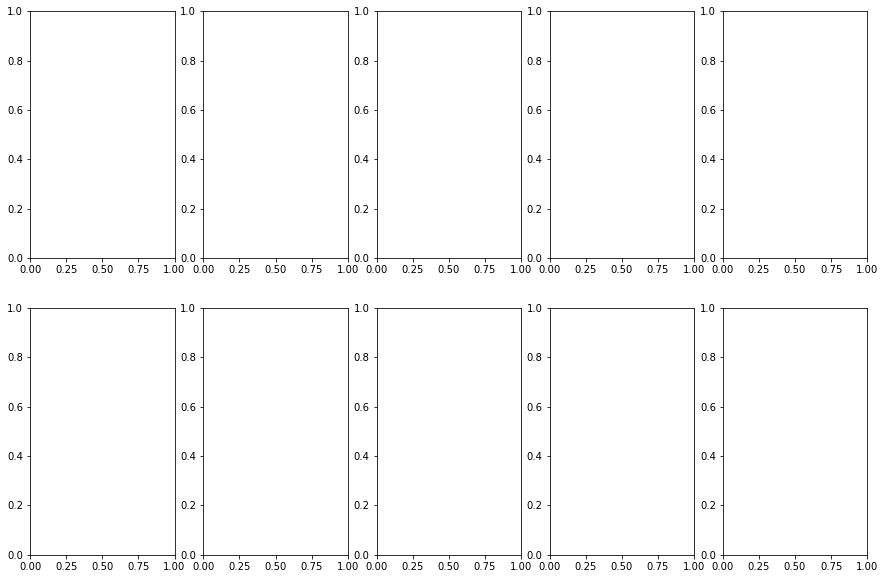

In [20]:
TTA_boolean = 1 #0

preds = []
direc = "../input/cassava-leaf-disease-classification/"
test_direc = direc + "test_images/"
sample_sub_csv = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

if TTA_boolean == 1:
    test_gen = ImageDataGenerator(
                        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                        rotation_range=40,
                         width_shift_range=[0.1,0.4],
                         height_shift_range=[0.1,0.4],
                         zoom_range=[0.2,0.4],
                        fill_mode = 'reflect'
                                   )

    #fig = plt.figure(figsize=(15, 10))
    for image in sample_sub_csv.image_id:
        img = keras.preprocessing.image.load_img('../input/cassava-leaf-disease-classification/test_images/' + image)
        img = keras.preprocessing.image.img_to_array(img)
        img = keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
        tta_steps = 10
        predictions = []
        for i in range(tta_steps):
            img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
            img_augmented = test_gen.flow(img,batch_size=1) 
            #fig.add_subplot(2, 5, i+1)
            #print(np.squeeze(img_augmented[0]))
            #plt.imshow(np.squeeze(img_augmented[0]).astype(int))
            preds_tta = EfficientNet_model.predict_generator(img_augmented)
            predictions.append(preds_tta)
           

        pred = np.mean(predictions, axis=0)

        preds.append(np.argmax(pred))

else:
    pass  
        
final_submission = pd.DataFrame({'image_id': sample_sub_csv.image_id, 'label': preds})
final_submission.to_csv('submission.csv', index=False)